## Trabajo Práctico 1 - Técnicas de Diseño


### Primera Parte: Problema de K-merge por División y Conquista


#### Introducción

El problema de K-merge es el siguiente: se tienen $K$ arreglos ordenados, y se quiere quiere obtener un único arreglo, también ordenado, con todos los elementos de los arreglos originales (inclusive si hay repetidos). Por simplicidad para los diferentes análisis se puede suponer que todos los arreglos tienen exactamente $h$ elementos (por ende, la cantidad total de elementos es $n = k ∗ h$).

Para resolver este problema, es posible que hayan visto en Algoritmos y Programación II un algoritmo que resuelve este problema utilizando un Heap. Nos referiremos a este como el algoritmo que utiliza Heaps.
La idea en este caso será plantear otra solución y analizarla. Se propone el siguiente algoritmo por división y conquista, con semejanzas a mergesort.

1. Caso base: cuando quede un único arreglo, simplemente devolver dicho arreglo.
2. En el caso general, dividir la cantidad de arreglos entre la primera mitad, y la segunda mitad, y luego invocar recursivamente para cada mitad de arreglos. Es decir, si tenemos cuatro arreglos, invocamos para los primeros 2, y luego para los segundos 2. Al terminar los llamados recursivos, tenemos dos arreglos ordenados. Estos deberán ser intercalados ordenadamente, tal cual se realiza en mergesort.


#### 1. Determinar, utilizando el Teorema Maestro, cuál sería la complejidad del algoritmo propuesto.


En cada llamada tenemos $n = k * h$ elementos, y hacemos 2 llamadas recursivas. Cada una tiene la mitad de los arreglos, por lo que la cantidad de elementos en la llamada recusriva es $n_r = \frac{k}{2} * h = \frac{n}{2}$. Intercalar ordenadamente los dos arreglos resultantes es una operación lineal a la cantidad total de elementos.

Por lo tanto, la ecuación de recurrencia es:

$$
T(n) = 2T\left(\frac{n}{2}\right) + O(n) \\
\begin{align*}
\Rightarrow A &= 2, \\
B &= 1, \\
C &= 1
\end{align*} \\
$$

Entonces, la complejidad resulta:

$$
\Rightarrow log_A(B) = log_2(2) = 1 = C \\
$$

$$
\Rightarrow T(n) = \bm{O(n * log(n))}
$$


#### 2. Describir el algoritmo que utiliza heaps, y determinar su complejidad.


El algoritmo que utiliza heaps es el siguiente:

1. Se crea un heap con los primeros elementos de cada arreglo.
2. Se extrae el mínimo del heap, y se agrega al arreglo final.
3. Se agrega al heap el siguiente elemento del arreglo del que se extrajo el mínimo.
4. Se repite 2 y 3 hasta que el heap esté vacío.

Para encontrar la complejidad, podemos ver la complejidad de cada paso:

1. $O(k)$ para crear el heap (copiar $k$ elementos a un arreglo y utilizar heapify).
2. $O(log(k))$ para extraer el mínimo.
3. $O(log(k))$ para agregar un elemento al heap.
4. Los 2 pasos anteriores se hacen una totalidad de $n-k=k*h-k$ veces, es decir, para todos los elementos restantes.

Entonces, la complejidad es $O(k + (k*h-k)*log(k)) = O(k + k*h*log(k) - k*log(k)) = O(k*h*log(k)) = \bm{O(n*log(k))}$.


#### 3. Implementar ambos algoritmos, y hacer mediciones (y gráficos) que permitan entender si las complejidades obtenidas para cada uno se condicen con la realidad.


Por División y Conquista:


In [5]:
def merge_sorted(list_1: list, list_2: list) -> list:
    i = 0
    j = 0
    out = []
    while i < len(list_1) and j < len(list_2):
        if list_1[i] < list_2[j]:
            out.append(list_1[i])
            i += 1
        else:
            out.append(list_2[j])
            j += 1
    out.extend(list_1[i:])
    out.extend(list_2[j:])
    return out


def merge_dq(lists: list[list]) -> list:
    middle = len(lists) // 2
    if len(lists) == 1:
        return lists[0]
    lista_1 = merge_dq(lists[:middle])
    lista_2 = merge_dq(lists[middle:])
    return merge_sorted(lista_1, lista_2)


assert merge_dq([[1, 2, 6], [3, 5, 7], [4, 8, 9]]) == [1, 2, 3, 4, 5, 6, 7, 8, 9]


Con Heaps:


In [6]:
# Notar que el módulo de heapq de Python ya implementa este algoritmo con la función merge. A continuación una implementación propia.
import heapq


def merge_heaps(lists: list[list]) -> list:
    heap = [(x[0], list_index, 0) for list_index, x in enumerate(lists)]
    heapq.heapify(heap)
    out = []
    while heap:
        value, list_index, i = heapq.heappop(heap)
        out.append(value)
        if i + 1 < len(lists[list_index]):
            new_value = lists[list_index][i + 1]
            heapq.heappush(heap, (new_value, list_index, i + 1))
    return out


assert merge_heaps([[1, 2, 6], [3, 5, 7], [4, 8, 9]]) == [1, 2, 3, 4, 5, 6, 7, 8, 9]


Funciones auxiliares para medir tiempos:


In [7]:
from typing import Callable, Iterable
from time import time
import random
import numpy as np
from concurrent.futures import ProcessPoolExecutor, Future

random.seed(123)
np.random.seed(123)


def get_random_lists(k: int, h: int) -> list[list[np.float64]]:
    """
    Returns k sorted random lists of length h
    """
    return [sorted(np.random.random(h)) for _ in range(k)]


def time_func(func: Callable, *args: Iterable) -> float:
    """
    Returns the milliseconds it took to execute func with args
    """
    start = time()
    func(*args)
    return time() - start


def as_results(futures: Iterable[Future]) -> list:
    """
    Returns the results of the futures
    """
    return [f.result() for f in futures]


def get_times(k_list: Iterable[int], h: int) -> tuple[list[float], list[float]]:
    """
    Times the merge_dq and merge_heaps algorithms with random lists of length h and k elements,
    for each k in k_list
    """
    with ProcessPoolExecutor() as e:
        print("Generating random lists...")
        max_k = max(k_list)
        random_lists = get_random_lists(max_k, h)

        print("Timing merging algorithms...")
        times_dq_futures = []
        times_heaps_futures = []
        for k in k_list:
            lists = random_lists[:k]
            times_dq_futures.append(e.submit(time_func, merge_dq, lists))
            times_heaps_futures.append(e.submit(time_func, merge_heaps, lists))

        times_dq = as_results(times_dq_futures)
        times_heaps = as_results(times_heaps_futures)
        print("Done")
        return times_dq, times_heaps


Obtención de los tiempos de ejecución:


In [8]:
K = 10000  # Cantidad de listas
H = 100  # Elementos por lista

SAMPLES = 200

x = np.linspace(1, K, SAMPLES, dtype=int)
times_dq, times_heaps = get_times(x, H)


Generating random lists...
Timing merging algorithms...
Done


Gráficos:


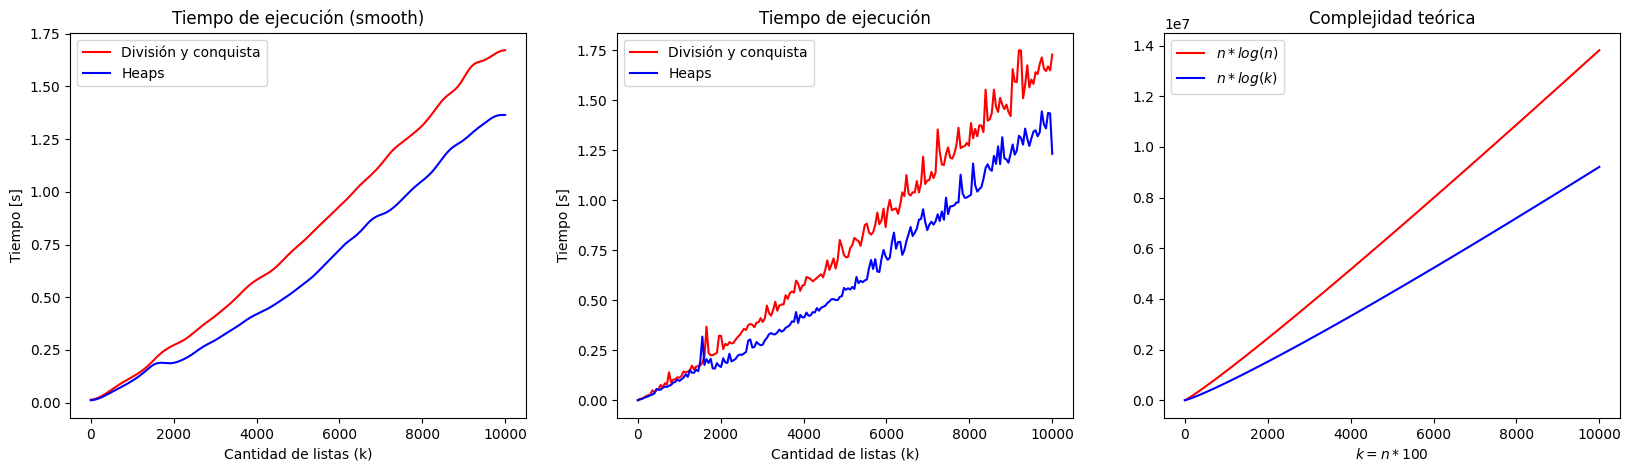

In [24]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d

SMOOTH_SIGMA = 4  # the bigger, the smoother


def nlogn(k):
    return (k * H) * np.log(k * H)


def nlogk(k):
    return (k * H) * np.log(k)


def plot_times(
    x: Iterable[int], times_dq: Iterable[float], times_heaps: Iterable[float]
):
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # smooth lines
    times_dq_smooth = gaussian_filter1d(times_dq, sigma=SMOOTH_SIGMA)
    times_heaps_smooth = gaussian_filter1d(times_heaps, sigma=SMOOTH_SIGMA)

    for ax in (ax1, ax2):
        ax.set_xlabel("Cantidad de listas (k)")
        ax.set_ylabel("Tiempo [s]")

    sns.lineplot(
        x=x, y=times_dq_smooth, label="División y conquista", ax=ax1, color="red"
    )
    sns.lineplot(x=x, y=times_heaps_smooth, label="Heaps", ax=ax1, color="blue")
    ax1.set_title("Tiempo de ejecución (smooth)")

    sns.lineplot(x=x, y=times_dq, label="División y conquista", ax=ax2, color="red")
    sns.lineplot(x=x, y=times_heaps, label="Heaps", ax=ax2, color="blue")
    ax2.set_title("Tiempo de ejecución")

    sns.lineplot(x=x, y=[nlogn(k) for k in x], label="$n*log(n)$", ax=ax3, color="red")
    sns.lineplot(x=x, y=[nlogk(k) for k in x], label="$n*log(k)$", ax=ax3, color="blue")
    ax3.set_xlabel(rf"$k = n * {H}$")
    ax3.set_title("Complejidad teórica")


plot_times(x, times_dq, times_heaps)


Se puede ver como los gráficos se comportan de forma similar a la complejidad teórica, con una diferencia de escala. El algoritmo que utiliza los heaps parece ser cada vez más eficiente a medida que aumenta la cantidad de arreglos, en comparación con el algoritmo por división y conquista.


#### 4. En caso que la complejidad obtenida en el punto 1 no se condiga con la realidad, indicar por qué (qué condición falla). En dicho caso, se requiere llegar a la complejidad correcta (no solamente enunciarla, sino demostrar cuál es).


Mirando los gráficos del punto anterior, parece que las complejidades obtenidas coinciden con la realidad.


#### 5. Indicar cualquier conclusión adicional que les parezca relevante en base a lo analizado.


> TODO


### Segunda Parte: ¡Problema de contrabando!


#### Historia y Estado de la situación

Genovia y Krakozhia son países limítrofes muy disímiles. Entre sus muchas diferencias, se encuentran los productos que se pueden producir o ingresar a uno y otro país. En particular, Krakozhia pertenece a la Unión Europea, haciendo que sea muy restrictiva con algunas clases de productos.

Por el contrario, el Reino de Genovia casi no tiene restricciones ni en el acceso ni en la producción de productos. Este es uno de los problemas que tienen con sus vecinos de la Unión Europea (el otro, es ser considerando un paraíso fiscal).

Es muy común que ciudadanos de Krakozhia viajen a Genovia, y aprovechen su estadía para comprar productos que no podrían comprar en su país. Incluso hay quienes aprovechan para comprar bastantes productos, para luego revenderlos en Krakozhia, a un alto precio. ¿El problema? es ilegal entrar con esos productos a la Unión Europea, y en particular a Krakozhia, por lo que sus agentes aduaneros deberían confiscarles los productos (y potencialmente labrarles un acta o algún otro tipo de sansión). ¿Lo bueno? Los agentes aduaneros de Krakozhia no destacan por su honestidad. El menos corrupto no puede armar una declaración jurada de ingresos medianamente creíble. Esto quiere decir que al pasar por la aduana, un agente aduanero puede pedir, en concepto de soborno, una cierta cantidad de algunos productos que se lleve consigo (luego de revisarlos), el cual debe pagarse sí o sí, si no se quiere caer en serios problemas.

#### Planteo del problema

Queremos pasar mercadería de contrabando de Genovia a Krakozhia. La mercadería viene en paquetes que no podemos abrir. Cada paquete i trae Xi unidades de un determinado tipo de producto j. Podríamos llegar a tener varios paquetes del mismo tipo de producto j, incluso con diferente cantidad de unidades. También podemos tener diferentes paquetes de diferentes productos. Es decir, cada paquete (in-abrible) es de una cantidad específica de un tipo específico, y en total para un tipo específico j tenemos la suma de Xi unidades, para todos los i que sean de ese tipo.

Para nuestro ejemplo, supongamos que tenemos un paquete que trae 8 cajetillas de cigarrillos sabor arándano. Otro paquete trae 5 cajetillas de lo mismos cigarrillos. Otro paquete puede traer 5 botellitas de 100ml de vodka radioactivo, etc...

Al pasar por la aduana, el corrupto funcionario puede indicarnos que _“por acá no pasan sin dejarme al menos 6 cajetillas de cigarrillos de arándano”_.

Ante la imposibilidad de abrir y/o separar los paquetes, es claro que en dicho caso nos conviene dejar el paquete de 8 (no podemos abrirlo para sacar 6 de allí. . . sino la movida sería muy evidente). Si el oficial hubiera dicho que hay que dejar al menos 10 cajetillas, habría sido necesario dejar ambos paquetes para un total de 13 unidades de dicho producto. Si este hubiera dicho que le dejemos una cajetilla de cigarrillos y una botellita de vodka, tendríamos que dejar el paquete de 5 botellitas de vodka y el paquete de 5 cajetillas de cigarrillos.


#### 1. Describir e implementar un algoritmo greedy que, dado un input con los productos que se tienen, y lo pedido como soborno, nos permita salir airosos de la situación, con la mayor cantidad de productos posibles. Justificar por qué el algoritmo es, efectivamente, greedy. Considerar que siempre se nos pedirá una cantidad de productos en existencias (en nuestro ejemplo anterior, no nos habrían pedido que dejemos 7 botellas de vodka radioactivo, ni tampoco mandarinas del Sahara).


AA

In [ ]:
Product = str

def greedy(packages: dict[Product, list[int]], bribes: dict[Product, int]) -> dict[Product, list[int]]:
    chosen_packages: dict[Product, list[int]] = {}
               
    for product, amount_needed in bribes.items():
        available_amounts = sorted(packages[product])
        start = 0
        end = 0
        acumulated = 0
        
        while acumulated != amount_needed:
            if acumulated < amount_needed:
                acumulated += available_amounts[end]
                end += 1
            else:
                reduced = acumulated - available_amounts[start]
                if reduced >= amount_needed:
                    start += 1
                else:
                    # Ya no se puede achicar más el intervalo
                    break
                
        chosen_packages[product] = available_amounts[start:end]

    return chosen_packages


#### 2. Con las mismas consideraciones que en el punto anterior, describir e implementar un algoritmo (que sea óptimo) que resuelva el problema utilizando programación dinámica.


> TODO


#### 3. Indicar y justificar la complejidad de ambos algoritmos propuestos. Indicar casos (características y ejemplos) de deficiencias en el algoritmo greedy propuesto, para los cuales este no obtenga una solución óptima.


> TODO


#### 4. Implementar un programa que utilice ambos algoritmos, realizar mediciones y presentar resultados comparativos de ambas soluciones, en lo que refiere a su optimalidad de la solución (no de su complejidad). Incluir en la entrega del tp los sets de datos utilizados para estas simulaciones (que deben estar explicados en el informe). Estos deben incluir al menos una prueba de volumen, indicando cómo es que fueron generadas.


> TODO
